In [1]:
import cartopy.crs as ccrs
import cartopy
import datetime as dt
import glob
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import netCDF4
import numpy as np
import os

In [2]:
exp_dir = '/glade/u/home/afox/work/jedi/Jedi_experiments/workflow/expts/colorado_cycle'

In [3]:
startday = 1
endday = startday + 1
startday = str(startday).zfill(2)
endday = str(endday).zfill(2)

hofx_file = os.path.join(exp_dir + '/' + 'jedi_letkf_out_obs_depth_2021-03-' + startday + 'T00:00:00Z_0000.nc')
datetime = '2021-03-' + startday + 'T00:00:00'
window_begin = '2021-03-' + startday + 'T:00:00'
window_end = '2021-03-' + endday + 'T00:00:00'
metric = 'oman' #'ObsValue'
field = 'snow_depth'
units = 'm'
output_path = './figures/'
plotformat = 'png'

colmin = None
colmax = None

In [4]:
odat = []
lons = []
lats = []
time = []

# Message file being read
print(" Reading "+hofx_file)

# Open the file
fh = netCDF4.Dataset(hofx_file)

if metric=='omb':
    odat_proc = fh.groups['ObsValue'].variables[field][:] - fh.groups['hofx0'].variables[field][:]
else:
    odat_proc = fh.groups[metric].variables[field][:]

# Read metadata
lons_proc = fh.groups['MetaData'].variables['longitude'][:]
lats_proc = fh.groups['MetaData'].variables['latitude'][:]
time_proc = fh.groups['MetaData'].variables['dateTime'][:]

for m in range(len(odat_proc)):
    odat.append(odat_proc[m])
    lons.append(lons_proc[m])
    lats.append(lats_proc[m])

fh.close()

 Reading /glade/u/home/afox/work/jedi/Jedi_experiments/workflow/expts/colorado_cycle/jedi_letkf_out_obs_depth_2021-03-01T00:00:00Z_0000.nc


In [5]:
# Figure filename
# ---------------
field_savename = field

savename = os.path.join(output_path, field_savename+"_"+metric+"_"+datetime+"."+plotformat)

# Set missing values to nans
missing = 9.0e+30
odat = np.where(np.abs(odat) < missing, odat, float("NaN"))
   
numobs = len(odat)

obarray = np.empty([numobs, 3])

obarray[:, 0] = odat
obarray[:, 1] = lons
obarray[:, 2] = lats

# Exclude observations north of 50 degrees latitude
obarray = obarray[obarray[:,2]<50.0]

/glade/u/home/afox/.conda/envs/xr/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: Warning: converting a masked element to nan.
  if __name__ == '__main__':
<string>:6: UserWarning: Warning: converting a masked element to nan.


In [6]:
obarray = obarray[obarray[:,2]<41.0]
obarray = obarray[obarray[:,2]>37.0]
obarray = obarray[obarray[:,1]<-103.5]
obarray = obarray[obarray[:,1]>-109.4]
smallobs = obarray[:,0]<0.001
obarray[smallobs,0] = 0

In [7]:
# Compute and print some stats for the data
# -----------------------------------------
stdev = np.nanstd(obarray[:, 0])  # Standard deviation
omean = np.nanmean(obarray[:, 0]) # Mean of the data
datmi = np.nanmin(obarray[:, 0])  # Min of the data
datma = np.nanmax(obarray[:, 0])  # Max of the data

print("Plotted data statistics: ")
print("Mean: ", omean)
print("Standard deviation: ", stdev)
print("Minimum ", datmi)
print("Maximum: ", datma)

Plotted data statistics: 
Mean:  0.40332095356364
Standard deviation:  0.8126176333233899
Minimum  0.0
Maximum:  4.304438591003418


In [8]:
# Norm for scatter plot
# ---------------------
norm = None


# Min max for colorbar
# --------------------
if np.nanmin(obarray[:, 0]) < 0:
    cmax = datma
    cmin = datmi
    cmap_obs = 'RdBu'
else:
    cmax = omean+stdev
    cmin = np.maximum(omean-stdev, 0.0)
    cmap_obs = 'viridis'

if metric == 'PreQC' or metric == 'EffectiveQC':
    cmin = datmi
    cmax = datma

# If using omb then use standard deviation for the cmin/cmax
if metric=='omb' or metric=='ombg' or metric=='oman':
    cmax = stdev
    cmin = -stdev

# Override with user chosen limits
if (colmin!=None):
    print("Using user provided minimum for colorbar")
    cmin = colmin
if (colmax!=None):
    print("Using user provided maximum for colorbar")
    cmax = colmax   

 Saving figure as ./figures/snow_depth_oman_2021-03-01T00:00:00.png 



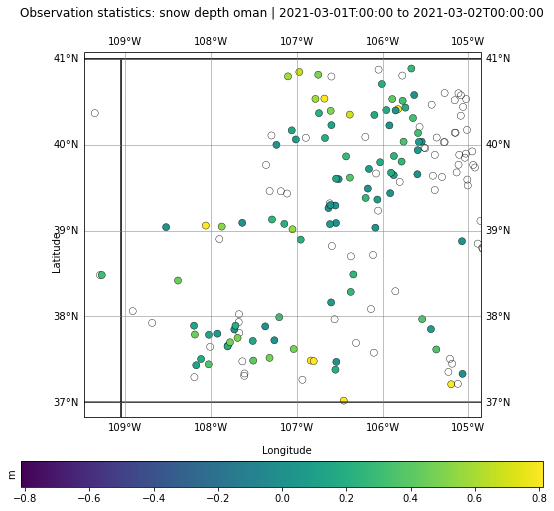

In [9]:
# Create figure
# -------------
fig = plt.figure(figsize=(15, 8))

# initialize the plot pointing to the projection
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=0))

# plot grid lines
gl = ax.gridlines(crs=ccrs.PlateCarree(central_longitude=0), draw_labels=True,
                      linewidth=1, color='gray', alpha=0.5, linestyle='-')

gl.xlabel_style = {'size': 10, 'color': 'black'}
gl.ylabel_style = {'size': 10, 'color': 'black'}
#gl.xlocator = mticker.FixedLocator(
#    [-180, -135, -90, -45, 0, 45, 90, 135, 179.9])
ax.set_ylabel("Latitude",  fontsize=7)
ax.set_xlabel("Longitude", fontsize=7)

ax.tick_params(labelbottom=False, labeltop=False, labelleft=False, labelright=False)

# scatter data
sc = ax.scatter(obarray[:, 1], obarray[:, 2],
                c=obarray[:, 0], s=50, linewidth=0.4, edgecolors='black',
                transform=ccrs.PlateCarree(), cmap=cmap_obs, vmin=cmin, vmax=cmax)

# colorbar
cbar = plt.colorbar(sc, ax=ax, orientation="horizontal", pad=.1, fraction=0.06,)
if not units==None:
    cbar.ax.set_ylabel(units, fontsize=10)

# plot globally
#ax.set_global()

# draw coastlines
ax.coastlines()
ax.add_feature(cartopy.feature.STATES)

# figure labels
plt.title("Observation statistics: "+field.replace("_"," ")+" "+metric+" | "+
            window_begin+" to "+window_end, y=1.08)
ax.text(0.45, -0.1,   'Longitude', transform=ax.transAxes, ha='left')
ax.text(-0.08, 0.4, 'Latitude', transform=ax.transAxes,
        rotation='vertical', va='bottom')

# show plot
print(" Saving figure as", savename, "\n")
#plt.savefig(savename, facecolor='w', dpi = 400)

In [10]:
geom_file = '/glade/work/afox/jedi/Jedi_experiments/input/wrf_hydro_nwm_files/colorado/geometry_nwm_long_range_snow.nc'


In [11]:

print('\nOpening ', geom_file, 'for reading')
ncfile = netCDF4.Dataset(geom_file, mode='r')
# Get metadata from the file
npx = ncfile.dimensions["west_east"].size
npy = ncfile.dimensions["south_north"].size
npz = 1
lons = ncfile.variables["XLONG"][:]
lats = ncfile.variables["XLAT"][:]
# Print field dimensions
print(" Grid dimensions", npx, 'x', npy, 'x', npz)

print('\nOpening ', geom_file, 'for reading')
ncfile = netCDF4.Dataset(geom_file, mode='r')



Opening  /glade/work/afox/jedi/Jedi_experiments/input/wrf_hydro_nwm_files/colorado/geometry_nwm_long_range_snow.nc for reading
 Grid dimensions 487 x 493 x 1

Opening  /glade/work/afox/jedi/Jedi_experiments/input/wrf_hydro_nwm_files/colorado/geometry_nwm_long_range_snow.nc for reading



Opening  /glade/u/home/afox/work/jedi/workflow/expts/colorado_oi_cycle/incremented_restarts/RESTART.2021030400_DOMAIN1 for reading
 Saving figure as ./figures/Colorado_Bkg_and_OmB_2021-03-04T00:00:00.png 



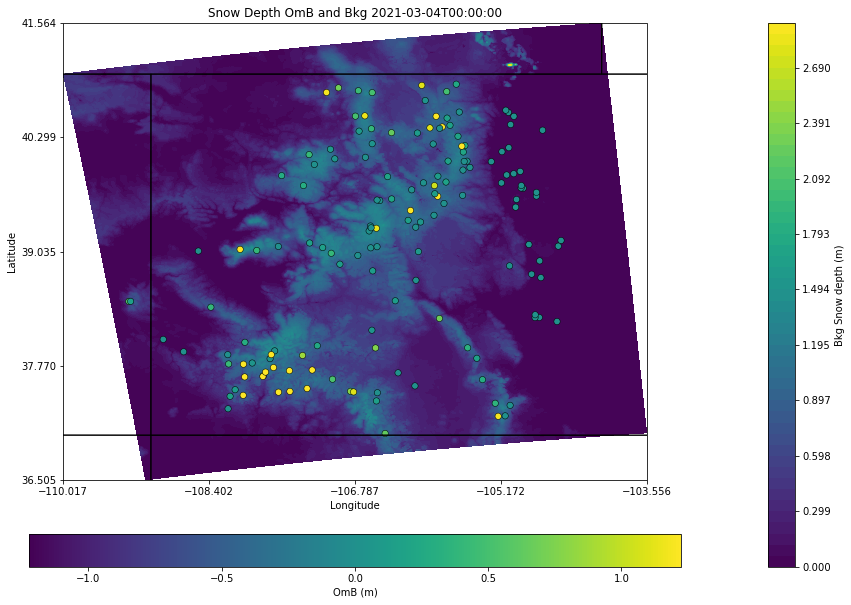

In [27]:
field_file = os.path.join(exp_dir+'/incremented_restarts/'+'RESTART.202103' + startday + '00_DOMAIN1')

#field_file = '/glade/u/home/afox/work/jedi/workflow/expts/colorado_debug/foo2021030400/member_000/RESTART.2021030500_DOMAIN1'

print('\nOpening ', field_file, 'for reading')
ncfile = netCDF4.Dataset(field_file, mode='r')

# Zero out array to fill with field
fld = np.zeros((npy, npx))
fld[:,:] = ncfile.variables["SNOWH"][:,:]

fmin = np.min(fld)
fmax = np.max(fld)
levels = np.linspace(fmin,fmax,50)

cmap = 'viridis'

# Create two dimensional contour plot of HGT

# Set the projection
projection = ccrs.PlateCarree()

# Create figure to hold plot
fig = plt.figure(figsize=(20, 10))

# Just one subplot for now
ax = fig.add_subplot(1, 1, 1, projection=projection)

    # Contour the field
im = ax.contourf(lons, lats, fld,
                     transform=projection,
                     cmap=cmap,
                     levels=levels)

sc = ax.scatter(obarray[:, 1], obarray[:, 2],
                c=obarray[:, 0], s=40, linewidth=0.5, edgecolors='black',
                transform=ccrs.PlateCarree(), cmap=cmap_obs, vmin=cmin, vmax=cmax)

# Add coast lines to the plot
ax.coastlines()

ax.add_feature(cartopy.feature.STATES)

# Add labels to the plot
ax.set_xticks(np.linspace(np.min(lons), np.max(lons), 5), crs=projection)
ax.set_yticks(np.linspace(np.min(lats), np.max(lats), 5), crs=projection)

ax.set_xlabel("Longitude")
ax.set_ylabel('Latitude')
ax.set_title("Snow Depth OmB and Bkg "+datetime)
#ax.set_global()

# Add a colorbar for the filled contour.
# colorbar
cbar = plt.colorbar(im, ax=ax, pad=-0.2, fraction=0.06,)
if not units==None:
    cbar.ax.set_ylabel("Bkg Snow depth (m)", fontsize=10)

# colorbar
cbar = plt.colorbar(sc, ax=ax, orientation="horizontal", pad=.1, fraction=0.06,)
if not units==None:
    cbar.ax.set_xlabel("OmB (m)", fontsize=10)

# show plot
savename = ('./figures/Colorado_Bkg_and_OmB_'+datetime+'.png')
print(" Saving figure as", savename, "\n")
#plt.savefig(savename, facecolor='w', dpi = 400)


Opening  /glade/u/home/afox/work/jedi/Jedi_experiments/workflow/expts/colorado_cycle/letkf_inc.lsm.ens.0.2021-03-02T00:00:00Z.PT0S for reading
 Saving figure as ./figures/Colorado_Increment_and_OmB_2021-03-01T00:00:00.png 



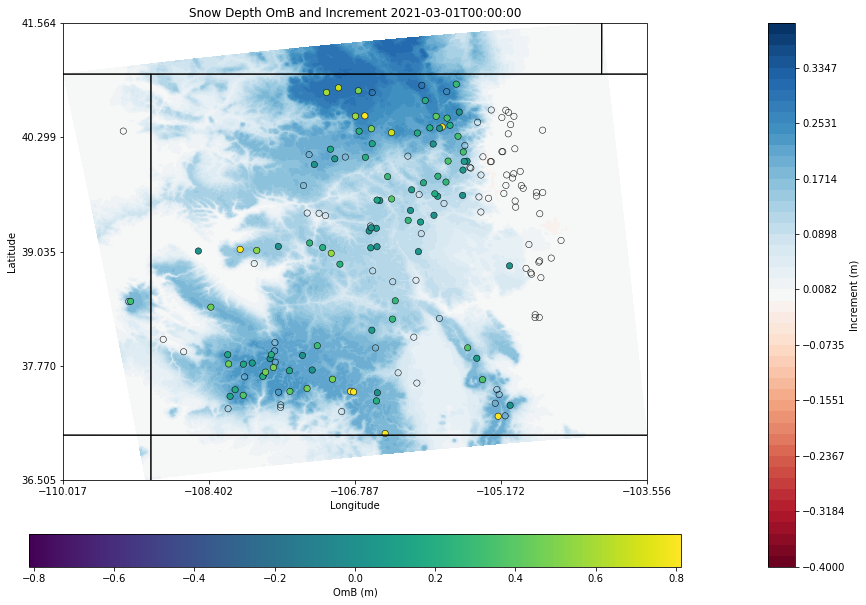

In [12]:
field_file = os.path.join(exp_dir+'/'+'letkf_inc.lsm.ens.0.2021-03-02T00:00:00Z.PT0S') 

print('\nOpening ', field_file, 'for reading')
ncfile = netCDF4.Dataset(field_file, mode='r')

# Zero out array to fill with field
fld_a = np.zeros((npy, npx))
fld_a[:,:] = ncfile.variables["SNOWH"][:,:]

fmin = -0.4 #np.min(fld_a)
fmax = 0.4 #np.max(fld_a)
levels = np.linspace(fmin,fmax,50)

cmap = 'RdBu'

# Create two dimensional contour plot of HGT

# Set the projection
projection = ccrs.PlateCarree()

# Create figure to hold plot
fig = plt.figure(figsize=(20, 10))

# Just one subplot for now
ax = fig.add_subplot(1, 1, 1, projection=projection)

    # Contour the field
im = ax.contourf(lons, lats, fld_a,
                     transform=projection,
                     cmap=cmap,
                     levels=levels)

sc = ax.scatter(obarray[:, 1], obarray[:, 2],
                c=obarray[:, 0], s=40, linewidth=0.5, edgecolors='black',
                transform=ccrs.PlateCarree(), cmap=cmap_obs, vmin=cmin, vmax=cmax)

# Add coast lines to the plot
ax.coastlines()

ax.add_feature(cartopy.feature.STATES)

# Add labels to the plot
ax.set_xticks(np.linspace(np.min(lons), np.max(lons), 5), crs=projection)
ax.set_yticks(np.linspace(np.min(lats), np.max(lats), 5), crs=projection)

ax.set_xlabel("Longitude")
ax.set_ylabel('Latitude')
ax.set_title("Snow Depth OmB and Increment "+datetime)
#ax.set_global()

# Add a colorbar for the filled contour.
# colorbar
cbar = plt.colorbar(im, ax=ax, pad=-0.2, fraction=0.06,)
if not units==None:
    cbar.ax.set_ylabel("Increment (m)", fontsize=10)

# colorbar
cbar = plt.colorbar(sc, ax=ax, orientation="horizontal", pad=.1, fraction=0.06,)
if not units==None:
    cbar.ax.set_xlabel("OmB (m)", fontsize=10)

# show plot
savename = ('./figures/Colorado_Increment_and_OmB_'+datetime+'.png')
print(" Saving figure as", savename, "\n")
plt.savefig(savename, facecolor='w', dpi = 400)

 Saving figure as ./figures/Colorado_Bkg_and_OmB_2021-03-04T00:00:00.png 



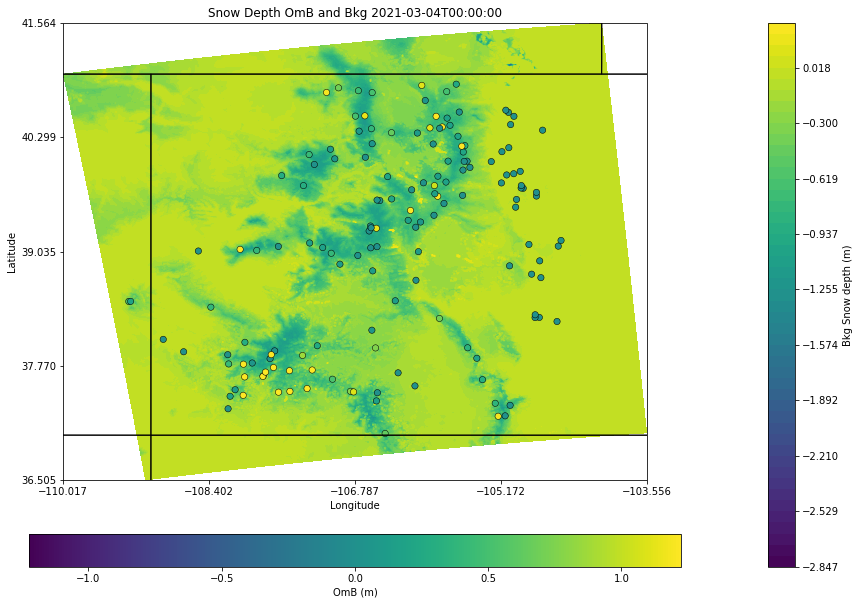

In [29]:
# Zero out array to fill with field

fld_i = fld_a - fld

fmin = np.min(fld_i)
fmax = np.max(fld_i)
levels = np.linspace(fmin,fmax,50)

cmap = 'viridis'

# Create two dimensional contour plot of HGT

# Set the projection
projection = ccrs.PlateCarree()

# Create figure to hold plot
fig = plt.figure(figsize=(20, 10))

# Just one subplot for now
ax = fig.add_subplot(1, 1, 1, projection=projection)

    # Contour the field
im = ax.contourf(lons, lats, fld_i,
                     transform=projection,
                     cmap=cmap,
                     levels=levels)

sc = ax.scatter(obarray[:, 1], obarray[:, 2],
                c=obarray[:, 0], s=40, linewidth=0.5, edgecolors='black',
                transform=ccrs.PlateCarree(), cmap=cmap_obs, vmin=cmin, vmax=cmax)

# Add coast lines to the plot
ax.coastlines()

ax.add_feature(cartopy.feature.STATES)

# Add labels to the plot
ax.set_xticks(np.linspace(np.min(lons), np.max(lons), 5), crs=projection)
ax.set_yticks(np.linspace(np.min(lats), np.max(lats), 5), crs=projection)

ax.set_xlabel("Longitude")
ax.set_ylabel('Latitude')
ax.set_title("Snow Depth OmB and Bkg "+datetime)
#ax.set_global()

# Add a colorbar for the filled contour.
# colorbar
cbar = plt.colorbar(im, ax=ax, pad=-0.2, fraction=0.06,)
if not units==None:
    cbar.ax.set_ylabel("Bkg Snow depth (m)", fontsize=10)

# colorbar
cbar = plt.colorbar(sc, ax=ax, orientation="horizontal", pad=.1, fraction=0.06,)
if not units==None:
    cbar.ax.set_xlabel("OmB (m)", fontsize=10)

# show plot
savename = ('./figures/Colorado_Bkg_and_OmB_'+datetime+'.png')
print(" Saving figure as", savename, "\n")
#plt.savefig(savename, facecolor='w', dpi = 400)

In [30]:
np.min(fld_i)

-2.8470494747161865